# Training Linear Models
> Chapter 4

- permalink: /04_training_linear_models

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
#collapse-show
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")
path = os.path.dirname(os.getcwd())
sys.path.append(path)
fig_folder = "ML_Lecture_04"

from common.filesio import FilesIO
from common.figsio import FiguresIO

# Linear regression using the Normal Equation

Linear Regression model prediction (vectorized form):
$\hat{y} = \theta \cdot x$

Recall that training a model means setting its parameters so that the model best fits the training set. For this purpose, we first need a measure of how well (or poorly) the model fits the training data. In Chapter 2 we saw that the most common performance measure of a regression model is the Root Mean Square Error (RMSE). Therefore, to train a Linear Regression model, you need to find the value of θ that minimizes the RMSE. In practice, it is simpler to minimize the Mean Square Error (MSE) than the RMSE, and it leads to the same result.

Let’s generate some linear-looking data for testing.

In [3]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

save figure generated_data_plot...


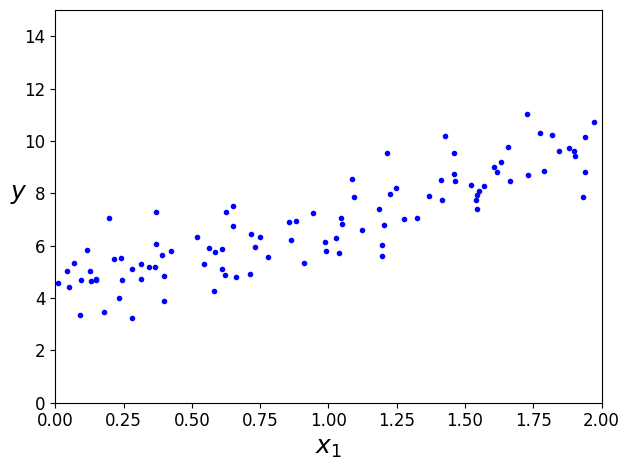

In [4]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
FiguresIO.saveFigures("generated_data_plot", fig_folder)
plt.show()

### The Normal Equation

To find the value of θ that minimizes the cost function, there is a closed-form solution —in other words, a mathematical equation that gives the result directly. This is called the Normal Equation.

Normal Equation:

$\hat{\theta} = (X^T X)^{-1}X^T Y$

Now let’s compute $\theta$ using the Normal Equation. We will use the inv() function from NumPy’s Linear Algebra module (np.linalg) to compute the inverse of a matrix, and the dot() method for matrix multiplication:

In [5]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [6]:
theta_best

array([[4.21509616],
       [2.77011339]])

The actual function that we used to generate the data is $y = 4 + 3\times1 + Gaussian\ noise$. We would have hoped for $θ_0 = 4$ and $θ_1 = 3$ instead of $θ_0 = 4.215$ and $θ_1 = 2.770$. Close enough, but the noise made it impossible to recover the exact parameters of the original function.

Now you can make predictions:

In [7]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

Let’s plot this model’s predictions:

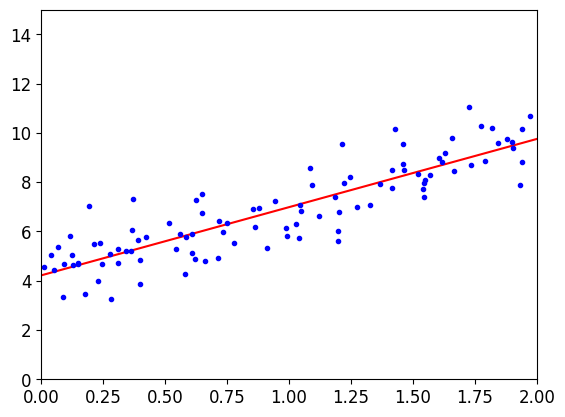

In [8]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

Adding a legend and axis labels:

save figure linear_model_predictions_plot...


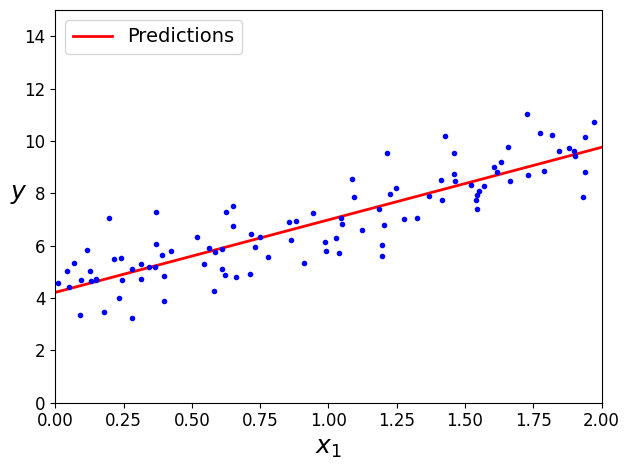

In [9]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
FiguresIO.saveFigures("linear_model_predictions_plot", fig_folder)
plt.show()

Performing linear regression using Scikit-Learn is quite simple:

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [11]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly:

In [12]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [13]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

This approach is more efficient than computing the Normal Equation, plus it handles edge cases nicely: indeed, the Normal Equation may not work if the matrix $X^T X$ is not invertible (i.e., singular), such as if m < n or if some features are redundant, but the pseudoinverse is always defined.

# Linear regression using batch gradient descent

The Normal Equation computes the inverse of $X^T X$, which is an $(n + 1) × (n + 1)$ matrix (where n is the number of features). The computational complexity of inverting such a matrix is typically about $O(n^{2.4})$ to $O(n^3)$ (depending on the implementation). In other words, if you double the number of features, you multiply the computation time by roughly $2^{2.4} = 5.3$ to $2^3 = 8$.

The SVD approach used by Scikit-Learn’s LinearRegression class is about $O(n^2)$. If you double the number of features, you multiply the computation time by roughly 4.

### Gradient Descent

Gradient Descent is a very generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost function.

An important parameter in Gradient Descent is the size of the steps, determined by the $learning\ rate$ hyperparameter. 
- If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time. 
- On the other hand, if the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before. This might make the algorithm diverge, with larger and larger values, failing to find a good solution.

Two main challenges with Gradient Descent: 
- converge to a local minimum, which is not as good as the global minimum
- the gradient is flat, taking a very long time to cross the plateau, and if you stop too early you will never reach the global minimum

# Batch gradient descent

To implement Gradient Descent, you need to compute the gradient of the cost function with regards to each model parameter $θ_j$. In other words, you need to calculate how much the cost function will change if you change $θ_j$ just a little bit. This is called a partial derivative. It is like asking “what is the slope of the mountain under my feet if I face east?” and then asking the same question facing north (and so on for all other dimensions, if you can imagine a universe with more than three dimensions).

$\frac{\partial}{\partial \theta_j} MSE(\theta) =
\frac{2}{m}\sum_{i=1}^{m} (\theta^T x^{(i)} - y^{(i)}) x_j^{(i)}$ 

The gradient vector, noted $\nabla_θ MSE(θ)$,

$\nabla_θ MSE(θ) = \frac{2}{m}X'(X\theta - y)$

Gradient Descent step is calculated as:

$\theta^{(next\ step)} = \theta - \eta \nabla_θ MSE(θ) $

In [14]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [15]:
theta

array([[4.21509616],
       [2.77011339]])

In [16]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

That’s exactly what the Normal Equation found! Gradient Descent worked perfectly. But what if you had used a different learning rate eta? The following figure shows the first 10 steps of Gradient Descent using three different learning rates (the dashed line represents the starting point).

In [17]:
#collapse-show
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

save figure gradient_descent_plot...


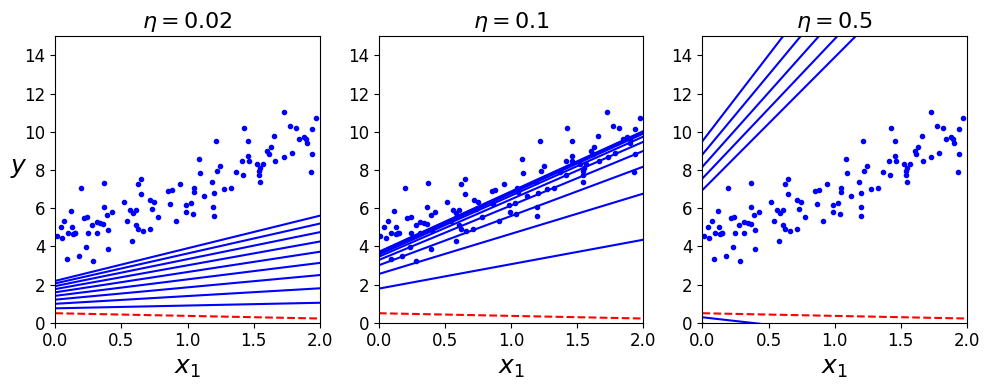

In [18]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

FiguresIO.saveFigures("gradient_descent_plot", fig_folder)
plt.show()

You may wonder how to set the number of iterations. If it is too low, you will still be far away from the optimal solution when the algorithm stops, but if it is too high, you will waste time while the model parameters do not change anymore. A simple solution is to set a very large number of iterations but to interrupt the algorithm when the gradient vector becomes tiny—that is, when its norm becomes smaller than a tiny number $\varepsilon$ (called the tolerance)—because this happens when Gradient Descent has (almost) reached the minimum.

# Stochastic Gradient Descent

The main problem with Batch Gradient Descent is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large. At the opposite extreme, Stochastic Gradient Descent just picks a random instance in the training set at every step and computes the gradients based only on that single instance. Obviously this makes the algorithm much faster since it has very little data to manipulate at every iteration.

In [19]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

save figure sgd_plot...


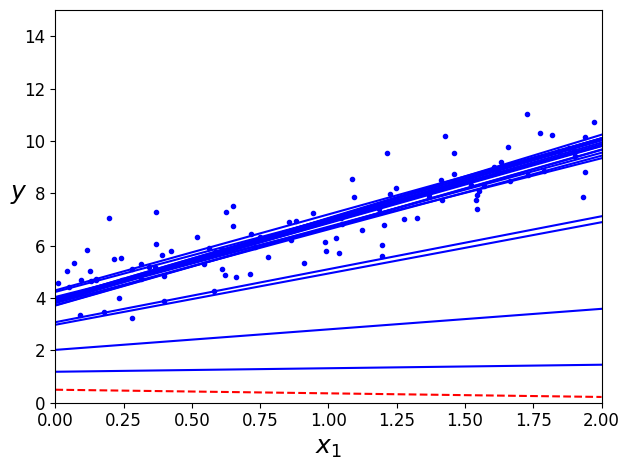

In [20]:
#collapse-show
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
FiguresIO.saveFigures("sgd_plot", fig_folder)                                # not shown
plt.show()                                           # not shown

In [21]:
theta

array([[4.21076011],
       [2.74856079]])

To perform Linear Regression using SGD with Scikit-Learn, you can use the SGDRegressor class, which defaults to optimizing the squared error cost function. The following code runs for maximum 1000 epochs (max_iter=1000) or until the loss drops by less than 1e-3 during one epoch (tol=1e-3), starting with a learning rate of 0.1 (eta0=0.1), and it does not use any regularization.

In [22]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [23]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

# Mini-batch gradient descent

The last Gradient Descent algorithm we will look at is called Mini-batch Gradient Descent. It is quite simple to understand once you know Batch and Stochastic Gradient Descent: at each step, instead of computing the gradients based on the full train‐ ing set (as in Batch GD) or based on just one instance (as in Stochastic GD), Mini-batch GD computes the gradients on small random sets of instances called mini-batches.

In [24]:
#collapse-show
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [25]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [26]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

save figure gradient_descent_paths_plot...


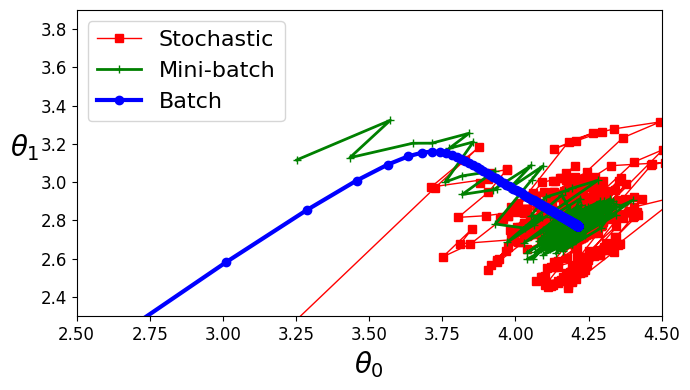

In [27]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
FiguresIO.saveFigures("gradient_descent_paths_plot", fig_folder)
plt.show()

The algorithm’s progress in parameter space is less erratic than with SGD, especially with fairly large mini-batches. As a result, Mini-batch GD will end up walking around a bit closer to the minimum than SGD. But, on the other hand, it may be harder for it to escape from local minima (in the case of problems that suffer from local minima, unlike Linear Regression as we saw earlier). 

# Polynomial regression

In [28]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

Let’s generate some nonlinear data, based on a simple quadratic equation.

In [29]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

save figure quadratic_data_plot...


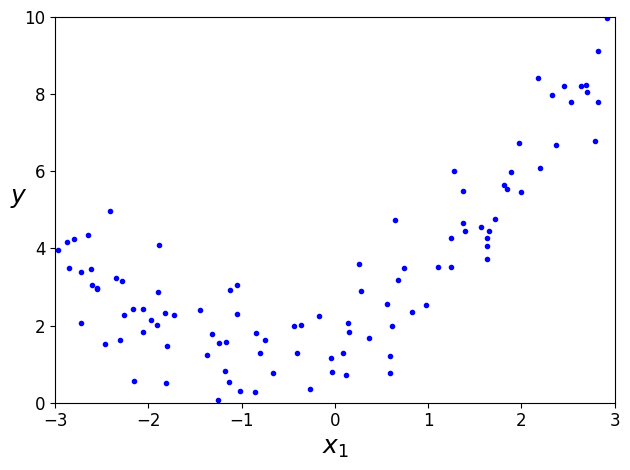

In [30]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
FiguresIO.saveFigures("quadratic_data_plot", fig_folder)
plt.show()

Let’s use Scikit-Learn’s Poly nomialFeatures class to transform our training data, adding the square (2nd-degree polynomial) of each feature in the training set as new features.

In [31]:
from sklearn.preprocessing import PolynomialFeatures    # 添加x的幂次项
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [32]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [33]:
-0.75275929**2

-0.566646548681304

X_poly now contains the original feature of X plus the square of this feature. Now you can fit a LinearRegression model to this extended training data

In [34]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

save figure quadratic_predictions_plot...


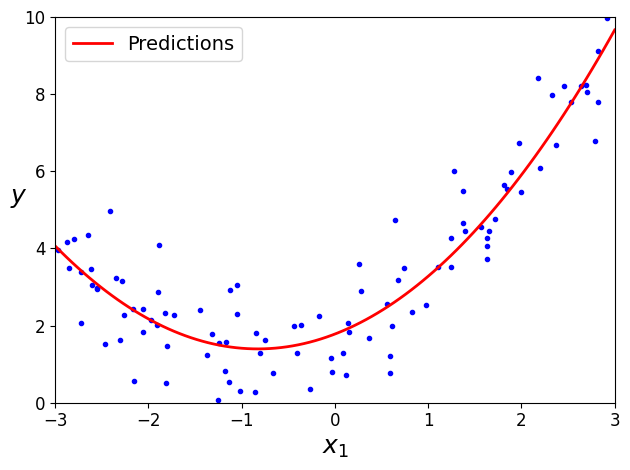

In [35]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
FiguresIO.saveFigures("quadratic_predictions_plot", fig_folder)
plt.show()

Not bad.

# Learning Curves

If you perform high-degree Polynomial Regression, you will likely fit the training data much better than with plain Linear Regression. The following example applies a 300-degree polynomial model to the preceding training data, and compares the result with a pure linear model and a quadratic model (2nd-degree polynomial). Notice how the 300-degree polynomial model wiggles around to get as close as possible to the training instances.

save figure high_degree_polynomials_plot...


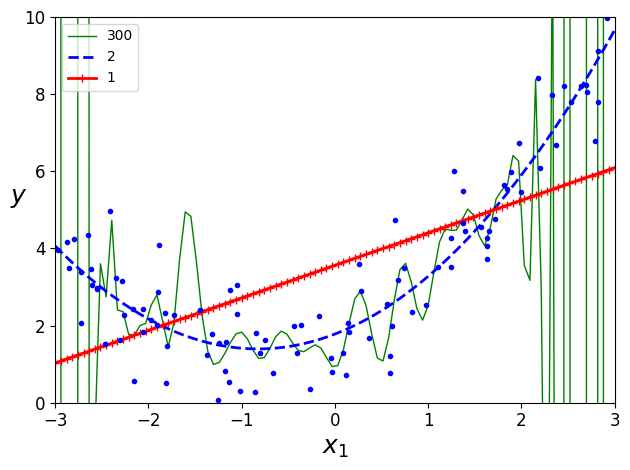

In [36]:
#collapse-show
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
FiguresIO.saveFigures("high_degree_polynomials_plot", fig_folder)
plt.show()

You used cross-validation to get an estimate of a model’s generalization performance. If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then your model is overfitting. If it performs poorly on both, then it is underfitting. This is one way to tell when a model is too simple or too complex.

Another way is to look at the learning curves: these are plots of the model’s performance on the training set and the validation set as a function of the training set size (or the training iteration). To generate the plots, simply train the model several times on different sized subsets of the training set. The following code defines a function that plots the learning curves of a model given some training data:

In [37]:
#collapse-show
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

save figure underfitting_learning_curves_plot...


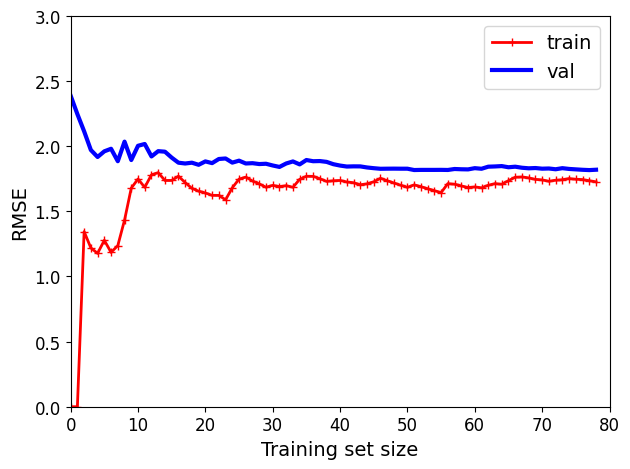

In [38]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
FiguresIO.saveFigures("underfitting_learning_curves_plot", fig_folder)
plt.show()                                      # not shown

These learning curves are typical of an underfitting model. Both curves have reached a plateau; they are close and fairly high. If your model is underfitting the training data, adding more train‐ ing examples will not help. You need to use a more complex model or come up with better features.

Now let’s look at the learning curves of a 10th-degree polynomial model on the same data.

save figure learning_curves_plot...


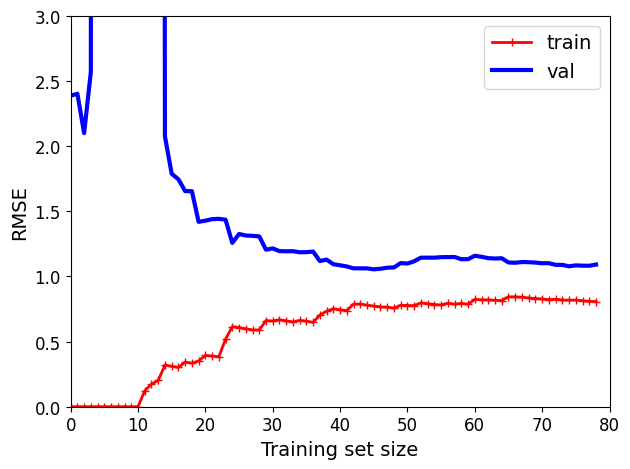

In [39]:
#collapse-show
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
FiguresIO.saveFigures("learning_curves_plot", fig_folder)
plt.show()                        # not shown

These learning curves look a bit like the previous ones, but there are two very important differences:
- The error on the training data is much lower than with the Linear Regression model.
- There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. However, if you used a much larger training set, the two curves would continue to get closer.

# Regularized models

A good way to reduce overfitting is to regularize the model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data. For example, a simple way to regularize a polynomial model is to reduce the number of polynomial degrees.

For a linear model, regularization is typically achieved by constraining the weights of the model. We will now look at Ridge Regression, Lasso Regression, and Elastic Net, which implement three different ways to constrain the weights.

### Ridge Regression

cost function: $J(\theta) = MSE(\theta) + \frac{1}{2}\alpha\sum_{i=1}^{n}\theta_i^2$

In [40]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

As with Linear Regression, we can perform Ridge Regression either by computing a closed-form equation or by performing Gradient Descent. The pros and cons are the same.

In [41]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [42]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55072189]])

### Tip
It is important to scale the data (e.g., using a StandardScaler) before performing Ridge Regression, as it is sensitive to the scale of the input features. This is true of most regularized models.

save figure ridge_regression_plot...


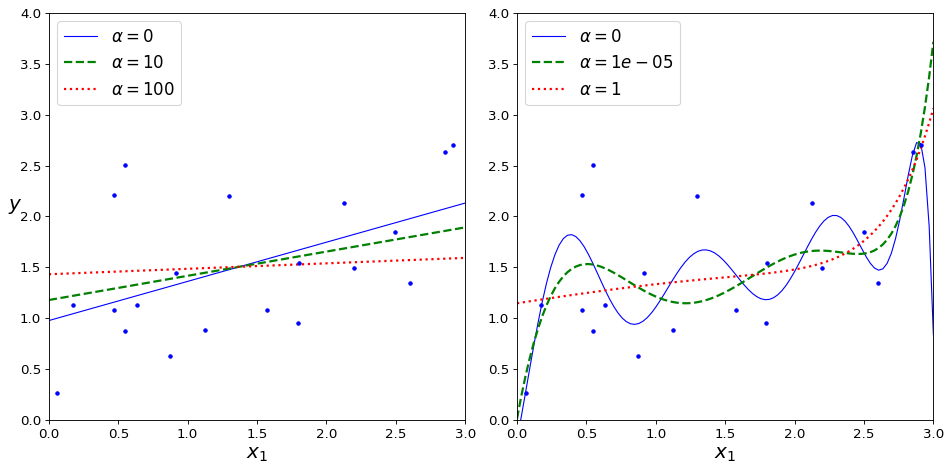

In [43]:
#collapse-show
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                ("std_scaler", StandardScaler()),
                ("regul_reg", model),
            ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(
            X_new, y_new_regul, style, linewidth=lw, 
            label=r"$\alpha = {}$".format(alpha)
        )
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(12, 6), dpi=80)
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

FiguresIO.saveFigures("ridge_regression_plot", fig_folder)
plt.show()

Note how increasing α leads to flatter (i.e., less extreme, more reasonable) predictions; this reduces the model’s variance but increases its bias.

**Note**: to be future-proof, we set `max_iter=1000` and `tol=1e-3` because these will be the default values in Scikit-Learn 0.21.

In [44]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

# Lasso Regression

Least Absolute Shrinkage and Selection Operator Regression (simply called Lasso Regression)

cost function: $J(\theta) = MSE(\theta) + \alpha\frac{1}{2}\sum_{i=1}^{n}|\theta_i|$

used to select varibles

An important characteristic of Lasso Regression is that it tends to completely eliminate the weights of the least important features (i.e., set them to zero). For example, the dashed line in the right plot below (with α = 10-7) looks quadratic, almost linear: all the weights for the high-degree polynomial features are equal to zero. In other words, Lasso Regression automatically performs feature selection and outputs a sparse model (i.e., with few nonzero feature weights).

save figure lasso_regression_plot...


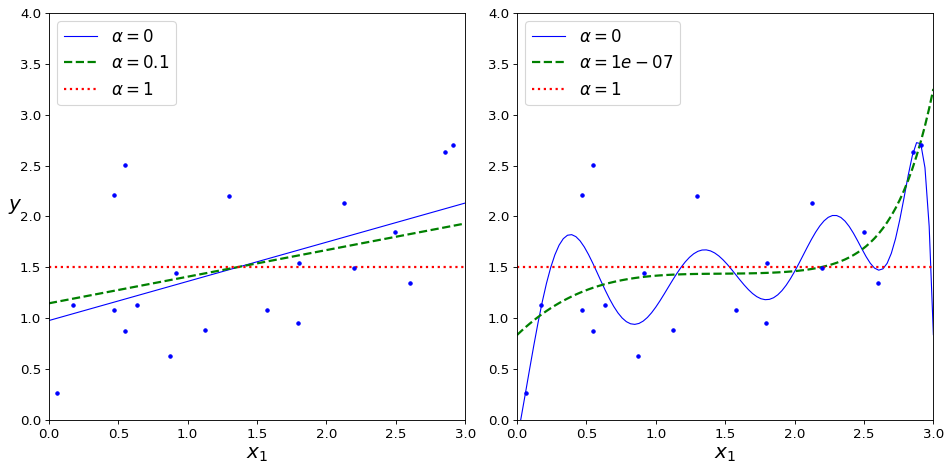

In [45]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(12, 6), dpi=80)
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

FiguresIO.saveFigures("lasso_regression_plot", fig_folder)
plt.show()

In [46]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

You can get a sense of why this is the case by looking at the below: on the top-left plot, the background contours (ellipses) represent an unregularized MSE cost function (α = 0), and the white circles show the Batch Gradient Descent path with that cost function. The foreground contours (diamonds) represent the l1 penalty, and the triangles show the BGD path for this penalty only $(\alpha \rightarrow \infty)$. Notice how the path first reaches $θ_1 = 0$, then rolls down a gutter until it reaches $θ_2 = 0$. On the top-right plot, the contours represent the same cost function plus an l1 penalty with $\alpha = 0.5$. The global minimum is on the $θ_2 = 0$ axis. BGD first reaches $θ_2 = 0$, then rolls down the gutter until it reaches the global minimum. The two bottom plots show the same thing but uses an l2 penalty instead. The regularized minimum is closer to $θ = 0$ than the unregularized minimum, but the weights do not get fully eliminated.

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [48]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

save figure lasso_vs_ridge_plot...


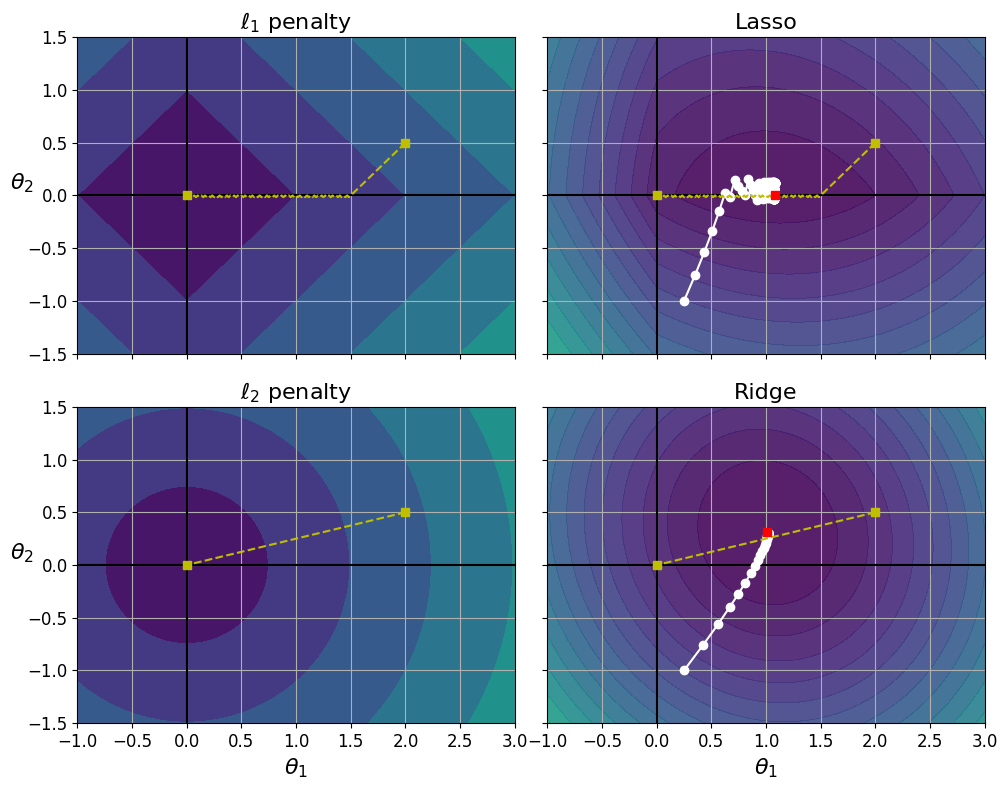

In [49]:
#collapse-show
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

FiguresIO.saveFigures("lasso_vs_ridge_plot", fig_folder)
plt.show()

# Elastic Net

Elastic Net is a middle ground between Ridge Regression and Lasso Regression.

Cost function: $J(\theta) = MSE(\theta) + r\alpha\frac{1}{2}\sum_{i=1}^{n}|\theta_i| + \frac{1}{2}\alpha\sum_{i=1}^{n}|\theta_i|$

In [50]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

# Early Stopping

A very different way to regularize iterative learning algorithms such as Gradient Descent is to stop training as soon as the validation error reaches a minimum. This is called early stopping.

In [51]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

Early stopping example:

In [52]:
#collapse-show
from sklearn.base import clone

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=1000.0, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error  
        best_epoch = epoch
        best_model = clone(sgd_reg)

Create the graph:

save figure early_stopping_plot...


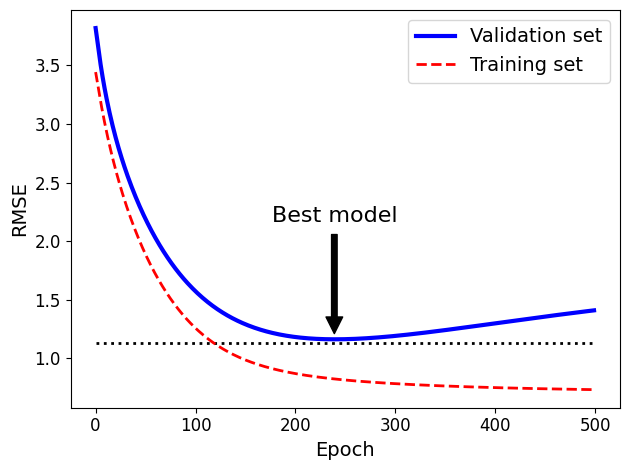

In [53]:
#collapse-show
sgd_reg = SGDRegressor(max_iter=1, tol=1000.0, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
FiguresIO.saveFigures("early_stopping_plot", fig_folder)
plt.show()

As the epochs go by, the algorithm learns and its prediction error (RMSE) on the training set naturally goes down, and so does its prediction error on the validation set. However, after a while the validation error stops decreasing and actually starts to go back up. This indicates that the model has started to overfit the training data. With early stopping you just stop training as soon as the validation error reaches the minimum. It is such a simple and efficient regularization technique that Geoffrey Hinton called it a “beautiful free lunch.”

In [54]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=1000.0, warm_start=True))

# Logistic regression

### Estimating Probabilities

Logistic Regression model estimated probability (vectorized form):

$\hat{p} = h_{\theta}(x) = \sigma(x^T\theta) $

Logistic function:

$\sigma(t) = \frac{1}{1+exp(-t)}$

save figure logistic_function_plot...


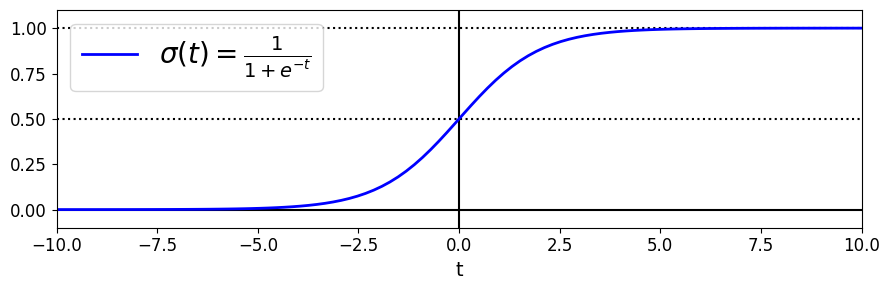

In [55]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
FiguresIO.saveFigures("logistic_function_plot", fig_folder)
plt.show()

Logistic Regression model prediction:

\begin{equation}
\hat{y}= \begin{cases}
0, &\text{if $\hat{p} <0.5$, }\\
1, &\text{if $\hat{p} \ge 0.5$}
\end{cases}
\end{equation}

The score t is often called the logit: this name comes from the fact that the logit function, defined as $logit(p) = log(p / (1 - p))$, is the inverse of the logistic function. Indeed, if you compute the logit of the estimated probability p, you will find that the result is t. The logit is also called the log-odds, since it is the log of the ratio between the estimated probability for the positive class and the estimated probability for the negative class.

Training and Cost Function:

\begin{equation}
c(\theta)=\begin{cases}
-log(\hat{p}) &\text{if y=1,}\\ 
-log(1-\hat{p}) &\text{if y=0,}
\end{cases}
\end{equation}

# Decision Boundaries

Let’s use the iris dataset to illustrate Logistic Regression. This is a famous dataset that contains the sepal and petal length and width of 150 iris flowers of three different species: Iris-Setosa, Iris-Versicolor, and Iris-Virginica.

In [56]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [57]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Let’s try to build a classifier to detect the Iris-Virginica type based only on the petal width feature. First let’s load the data:

In [58]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(int)  # 1 if Iris virginica, else 0

**Note**: To be future-proof we set `solver="lbfgs"` since this will be the default value in Scikit-Learn 0.22.

Now let’s train a Logistic Regression model:

In [59]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

Let’s look at the model’s estimated probabilities for flowers with petal widths varying from 0 to 3 cm.

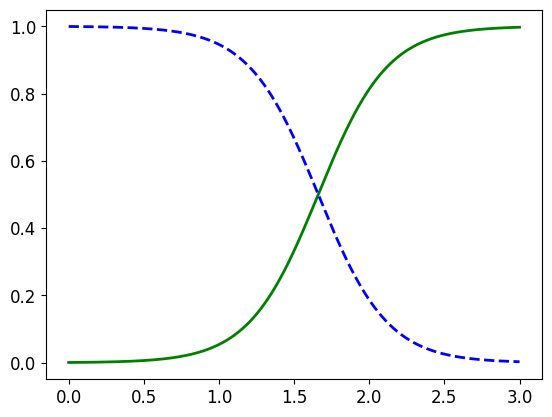

In [60]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

A bit fancier figure:

save figure logistic_regression_plot...


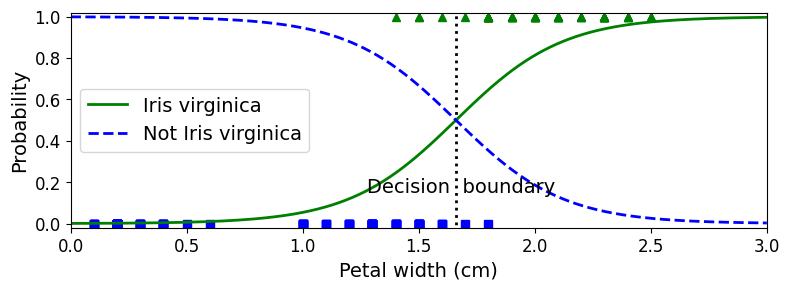

In [61]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
# plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
# plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
FiguresIO.saveFigures("logistic_regression_plot", fig_folder)
plt.show()

In [62]:
decision_boundary

array([1.66066066])

In [63]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

The figure below shows the same dataset but this time displaying two features: petal width and length. Once trained, the Logistic Regression classifier can estimate the probability that a new flower is an Iris-Virginica based on these two features. The dashed line represents the points where the model estimates a 50% probability: this is the model’s decision boundary. Note that it is a linear boundary. Each parallel line represents the points where the model outputs a specific probability, from 15% (bottom left) to 90% (top right). All the flowers beyond the top-right line have an over 90% chance of being Iris-Virginica according to the model.

save figure logistic_regression_contour_plot...


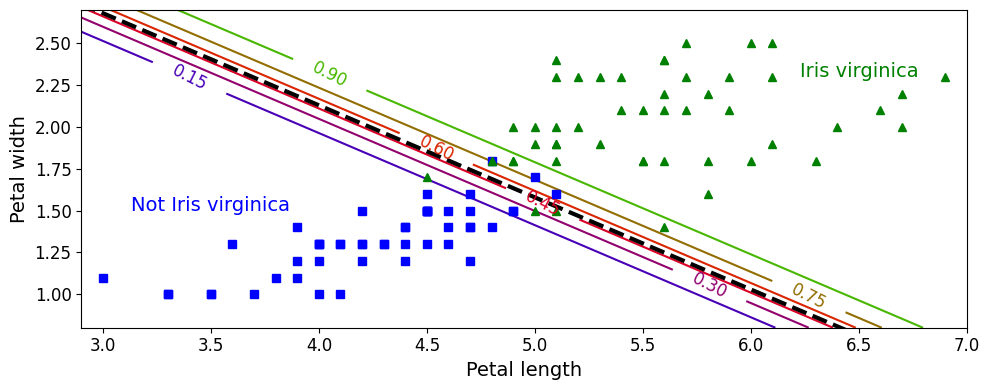

In [64]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
FiguresIO.saveFigures("logistic_regression_contour_plot", fig_folder)
plt.show()

# Softmax Regression

The Logistic Regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifiers. This is called Softmax Regression, or Multinomial Logistic Regression.

Softmax score for class k:
$$
s_k(x) = x^T\theta^{(k)}
$$

Softmax function:
$$
\hat{p}_k = \sigma( s(x) )_k = \frac{ exp(s_k(x)) }{ \sum_{j=1}^{K}exp(s_j(x)) }
$$

Cost function:
$$
J(\Theta) = -\frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K}y_k^{(i)}log(\hat{p}_k^{(i)})
$$

Let’s use Softmax Regression to classify the iris flowers into all three classes. Scikit- Learn’s LogisticRegression uses one-versus-all by default when you train it on more than two classes, but you can set the multi_class hyperparameter to "multinomial" to switch it to Softmax Regression instead. You must also specify a solver that supports Softmax Regression, such as the "lbfgs" solver (see Scikit-Learn’s documentation for more details). It also applies $l_2$ regularization by default, which you can control using the hyperparameter C.

In [65]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

save figure softmax_regression_contour_plot...


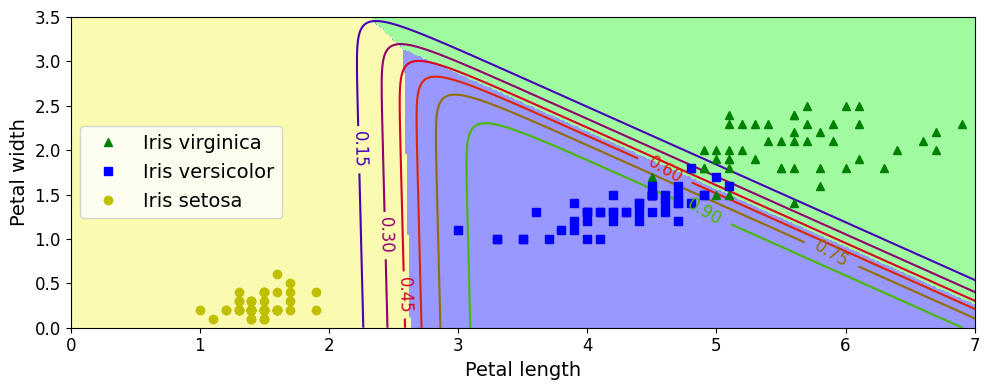

In [66]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
FiguresIO.saveFigures("softmax_regression_contour_plot", fig_folder)
plt.show()

In [67]:
softmax_reg.predict([[5, 2]])

array([2])

In [68]:
print(softmax_reg.predict_proba([[5, 2]]))

[[6.38014896e-07 5.74929995e-02 9.42506362e-01]]
